<a href="https://colab.research.google.com/github/JesusU076/Multiagentes/blob/main/M1_Actividad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#M1 Actividad
### Jesus Urquidez Calvo A00828368

In [245]:
!pip install mesa
from mesa import Agent, Model 

from mesa.space import MultiGrid

from mesa.time import SimultaneousActivation

from mesa.datacollection import DataCollector

# mathplotlib lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

import time
import datetime
import random

In [246]:
def get_grid(model):
    '''
    Esta es una función auxiliar que nos permite guardar el grid para cada uno de los agentes.
    param model: El modelo del cual optener el grid.
    return una matriz con la información del grid del agente.
    '''
    grid = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        for obj in cell_content:
          if isinstance(obj, RobotLimpieza):
            grid[x][y] = 2
          elif isinstance(obj, Celda):
            grid[x][y] = obj.estado
    return grid

class RobotLimpieza(Agent):
  '''
  Descripción
  '''
  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.sig_pos = None
    self.moves = 0

  def step(self):
    vecinos = self.model.grid.get_neighbors(
        self.pos, 
        moore = True,
        include_center = True)
    
    #maquina de estados
    for vecino in vecinos:
      if isinstance(vecino, Celda) and self.pos == vecino.pos:
        if vecino.estado == 1:
          #limpiar
          vecino.sig_estado = 0
          self.sig_pos = self.pos
        else: #vecino.estado == 0
          self.moves = self.moves + 1
          vecinos_2 = self.model.grid.get_neighborhood(
            self.pos, 
            moore = True,
            include_center = False)
          vecino.sig_estado = 0
          self.sig_pos = self.random.choice(vecinos_2)
        break

  def advance(self): 
    vecinos = self.model.grid.get_neighbors(
        self.pos, 
        moore = True,
        include_center = True)
    for vecino in vecinos:
      if isinstance(vecino, Celda) and self.pos == vecino.pos:
        vecino.estado = vecino.sig_estado
        break
    self.model.grid.move_agent(self, self.sig_pos)

class Celda(Agent):
  # 1 -> sucio
  # 0 -> limpio

  def __init__(self, unique_id, model, estado):
    super().__init__(unique_id, model)
    self.pos = unique_id
    self.estado = estado
    self.sig_estado = None

class Habitacion(Model):
  def __init__(self, M, N, num_agentes, porc_celdas_sucias):
    self.num_agentes = num_agentes
    self.porc_celdas_sucias = porc_celdas_sucias
    self.porc_celdas_limpias = 1 - porc_celdas_sucias
    self.grid = MultiGrid(M, N, False)
    self.schedule = SimultaneousActivation(self)
    self.moves = 0

    #colocacion de celdas sucias y limpias
    num_celdas_sucias = int(M * N * porc_celdas_sucias)
    for(content, x, y) in self.grid.coord_iter():
      num = random.randint(0,1)
      if num == 1 and num_celdas_sucias > 0:
        a = Celda((x,y), self, 1)
        num_celdas_sucias -= 1
      else:
        a = Celda((x,y), self, 0)
      self.grid.place_agent(a,(x,y))
      self.schedule.add(a)

    # colocacion de agentes robot
    for id in range(num_agentes):
      r = RobotLimpieza(id, self)
      self.grid.place_agent(r, (1,1))
      self.schedule.add(r)
    
    self.datacollector = DataCollector(
        model_reporters = {"Grid":get_grid})
  
  def step(self):
    self.datacollector.collect(self)
    self.schedule.step()

  def todoLimpio(self):
    for (content, x, y) in self.grid.coord_iter():
      for obj in content:
        if isinstance(obj, Celda) and obj.estado == 1:
          return False
    return True

  def numSucias(self):
    cont = 0
    for (content, x, y) in self.grid.coord_iter():
      for obj in content:
        if isinstance(obj, Celda) and obj.estado == 1:
          cont = cont + 1
    return cont


In [247]:
M = 3
N = 3
num_agentes = 1
porc_celdas_sucias = 0.6
tiempo_maximo = 0.01
conti = 0

model = Habitacion(M, N, num_agentes, porc_celdas_sucias)
start_time = time.time()
while((time.time() - start_time) < tiempo_maximo and not model.todoLimpio()):
  conti = conti + 1
  model.step()

contis = 0
for x in range(N*M, (N*M) + num_agentes):
  contis = contis + model.schedule.agents[x].moves

print(contis)
print('Numero de movimientos hechos en conjunto:', str(conti))
print('Celdas sucias despues de la simulación:', str(model.numSucias()))
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))

13
Numero de movimientos hechos en conjunto: 18
Celdas sucias despues de la simulación: 0
Tiempo de ejecución: 0:00:00.001948


In [248]:
all_grid = model.datacollector.get_model_vars_dataframe()
print(all_grid.to_string())

                                                   Grid
0   [[1.0, 1.0, 1.0], [0.0, 2.0, 1.0], [0.0, 0.0, 0.0]]
1   [[1.0, 1.0, 1.0], [0.0, 2.0, 1.0], [0.0, 0.0, 0.0]]
2   [[1.0, 1.0, 2.0], [0.0, 0.0, 1.0], [0.0, 0.0, 0.0]]
3   [[1.0, 1.0, 2.0], [0.0, 0.0, 1.0], [0.0, 0.0, 0.0]]
4   [[1.0, 1.0, 0.0], [0.0, 2.0, 1.0], [0.0, 0.0, 0.0]]
5   [[1.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 2.0, 0.0]]
6   [[1.0, 1.0, 0.0], [2.0, 0.0, 1.0], [0.0, 0.0, 0.0]]
7   [[2.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 0.0]]
8   [[2.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 0.0]]
9   [[0.0, 2.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 0.0]]
10  [[0.0, 2.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 0.0]]
11  [[0.0, 0.0, 0.0], [2.0, 0.0, 1.0], [0.0, 0.0, 0.0]]
12  [[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 2.0, 0.0]]
13  [[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [2.0, 0.0, 0.0]]
14  [[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 2.0, 0.0]]
15  [[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [2.0, 0.0, 0.0]]
16  [[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 2.0

In [249]:
%%capture

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=len(all_grid))

In [250]:
anim

#Analisis de los Resultados

Despues de haber animado la simulacion podemos dar a resaltar varios puntoS y relaciones. A mayor numero de agentes del tipo maquina de limpieza menor tiempo se le dedica a la limpieza ya que el numero de celdas limpiadas por unidad de tiempo aumenta. Por la misma naturaleza del agente tambien podemos deducir que la cantidad de movimientos por agente se disminuye debido a que la simulacion dura menos.

# Diagrama de maquina de estados
### Robot de limpieza 

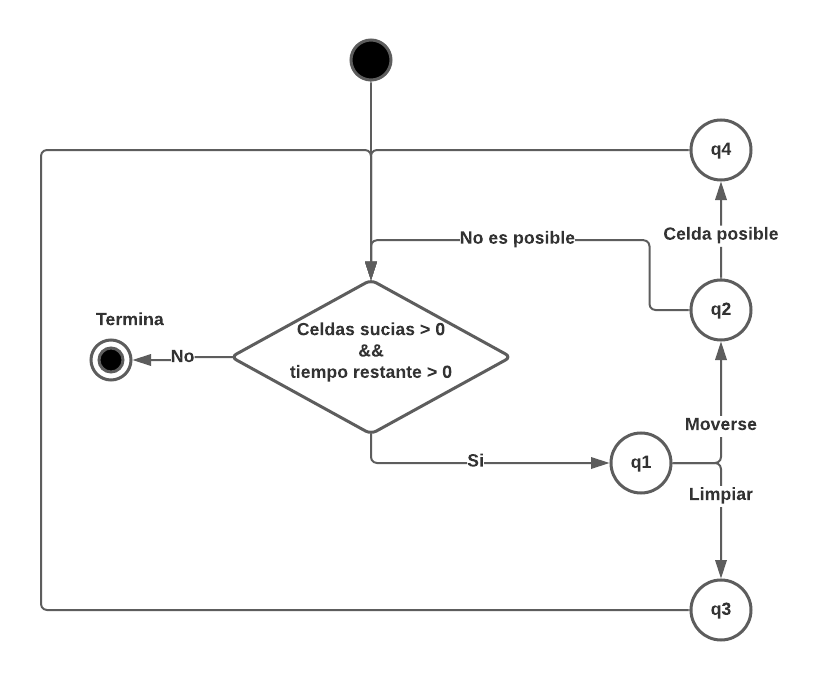